# FOM Optimization

#### Todo:

- Add SNID sybtypes to supliment CSP results
- Optimize FOM
- Repeate with scaled csp coordinates
- Check why some coordinates are not finite (or maybe their nan? not sure. check this too!).


In [1]:
import sys

import numpy as np
import pandas as pd
from astropy.table import Table
from pathlib import Path
from matplotlib import pyplot as plt
from sndata.csp import dr3
from sndata.sdss import sako18
from tqdm import tqdm

sys.path.insert(0, '../')
from phot_class import fom


In [2]:
dr3.download_module_data()
sako18.download_module_data()


/home/djperrefort/anaconda3/envs/Photometric-Classification/lib/python3.7/site-packages/sndata/_utils.py:118: UserWarning: Could not connect to https://portal.nersc.gov/project/dessn/SDSS/dataRelease/
  warn(f'Could not connect to {url}')
/home/djperrefort/anaconda3/envs/Photometric-Classification/lib/python3.7/site-packages/sndata/_utils.py:118: UserWarning: Could not connect to http://www.ioa.s.u-tokyo.ac.jp/~doi/sdss/
  warn(f'Could not connect to {url}')


# SNR Distributions

In [3]:
def get_csp_snr():
    """Return a 2d array of SNR ratios for each CSP DR3 target"""
    
    csp_snr = []
    for data_table in dr3.iter_data(verbose=True):
        snr = data_table['flux'] /  data_table['fluxerr']
        csp_snr.append(np.array(snr))
        
    return np.array(csp_snr)


In [4]:
def get_sdss_snr(subset=['SNIa']):
    """Return a 2d array of SNR ratios for each SDSS Sako18 target
    
    Args:
        subset (list): Only consider targets having the
                       given Sako18 classifications
    """
    
    master = sako18.load_table('master')
    is_sn = np.isin(master['Classification'], subset)

    sdss_obj_ids = master['CID'][is_sn]

    sdss_snr = []
    for obj_id in tqdm(sdss_obj_ids):
        data_table = sako18.get_data_for_id(obj_id)
        snr = data_table['flux'] /  data_table['fluxerr']
        sdss_snr.append(np.array(snr))

    return np.array(sdss_snr)


In [5]:
csp_snr = get_csp_snr()
csp_flat = np.concatenate(csp_snr)

sdss_snr = get_sdss_snr()
sdss_flat = np.concatenate(sdss_snr)
sdss_flat = sdss_flat[np.isfinite(sdss_flat)]


  1%|          | 5/499 [00:00<01:39,  4.94it/s]/home/djperrefort/anaconda3/envs/Photometric-Classification/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
100%|██████████| 499/499 [00:40<00:00, 12.40it/s]


In [6]:
def hist_snr_distributions(csp_snr_arr, sdss_snr_arr):
    """Plot SNR histograms for CSP and SDSS
    
    Args:
        csp_snr_arr  (ndarray): Flatt array of CSP SNR values
        sdss_snr_arr (ndarray): Flatt array of SDSS SNR values
    """
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

    ax1.hist(sdss_snr_arr, bins=np.arange(0, 100, 5), label='SDSS', density=False)
    ax2.hist(csp_snr_arr, label='CSP', color='C1', density=False)

    for survey_data, axis in zip([sdss_snr_arr, csp_snr_arr], (ax1, ax2)):
        median = np.median(survey_data)
        average = np.average(survey_data)
        axis.axvline(median, color='k', linestyle='--', label=f'median {median:.2f}')
        axis.axvline(average, color='k', linestyle=':', label=f'average {average:.2f}')

        axis.set_xlabel('SNR')
        axis.legend()


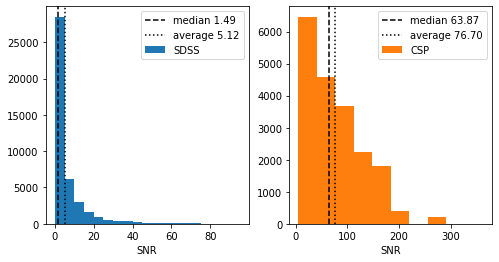

In [7]:
hist_snr_distributions(csp_flat, sdss_flat)


In [8]:
scale_func = np.median
scale_factor =  scale_func(sdss_flat) / scale_func(csp_flat)
scale_factor


0.02330931097745208

## Scaling Classification Coordinates

In [9]:
def get_csp_coords(results_dir):
    """Load CSP classification coordinates
    
    Args:
        results_dir (Path): Directory containing CSP fit results
    """

    # Load fitted coordinates
    csp_path = results_dir / 'csp_dr3_simple_fit_class.ecsv'
    csp_coords = Table.read(csp_path).to_pandas('obj_id')
    csp_coords['survey'] = 'CSP'

    # Load published subtypes from DR3
    csp_classes = dr3.load_table(2).to_pandas('SN')
    csp_classes = csp_classes.drop(['Dm15(tem)1', 'e_Dm15(tem)1', 'Nopt', 'NIR', 'Tspec'], axis='columns')
    csp_classes = csp_classes.rename({k: k.lower() for k in csp_classes.columns}, axis='columns')
    csp_classes = csp_classes.replace('---', 'unknown')  # Objects missing subtypes
    
    return csp_coords.join(csp_classes)


def get_sdss_coords(results_dir, snid_path=None):
    """Load SDSS classification coordinates
    
    Args:
        results_dir (Path): Directory containing SDSS fit results
        snid_path   (Path): Optional directory SNID typing results 
    """
    
    # Load fitted coordinates
    sdss_path = results_dir / 'sdss_sako18_simple_fit_class.ecsv'
    sdss_coords = Table.read(sdss_path).to_pandas('obj_id')
    sdss_coords['survey'] = 'SDSS'
    sdss_coords = sdss_coords.replace([np.inf, -np.inf], np.nan).dropna()

    # Load subtypes determined from SNID
    if snid_path:
        raise NotImplementedError
        
    return sdss_coords
    

In [10]:
ext_results_dir = Path('.').resolve().parent / 'results' / 'band_fits' / 'with_ext'

csp_coords = get_csp_coords(ext_results_dir)
sdss_coords = get_sdss_coords(ext_results_dir)

# Combine coordinates from SDSS and CSP
coordinates = pd.concat([csp_coords, sdss_coords])
coordinates = coordinates.set_index(['survey', coordinates.index])

# Make type column a combination of CSP and SNID subtypes
coordinates['type'] = coordinates['subtype1'].fillna('unknown')
coordinates.head()


/home/djperrefort/anaconda3/envs/Photometric-Classification/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


subtype1 subtype2 subtype3           x            y       type
survey obj_id                                                                 
CSP    2004ef     normal       HV       BL -210.236060  -376.926010     normal
       2004eo     normal        N       CL -940.832880 -1300.770366     normal
       2004ey     normal        N       CN -791.471463 -1638.082966     normal
       2004gs     normal        N       CL  -21.260538   -27.324840     normal
       2004gu  06gz-like      91T       SS -113.481092  -397.572841  06gz-like

In [11]:
def hist_coord_distributions(
        coord_df, 
        scale, 
        csp_bins=None, 
        sdss_bins=np.arange(-100, 100, 2.5),
        figsize=(8, 4)):
    """Plot histogram of classification coords for CSP adnd SDSS
    
    ``coord_df`` should have columns ``x`` and ``y`` and be indexible
    by survey (``CSP`` and ``SDSS``).
    
    Args:
        coord_df (dataframe): Dataframe of classification coordinates
        scale        (float): Rescale csp coordinates by the given value
        csp_bins   (ndarray): Bins to use when plotting the CSP histogram
        sdss_bins  (ndarray): Bins to use when plotting the CSP histogram
        figsize      (tuple): Size of the figure in inches
    """
    
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    for coord, axis in zip('xy', axes):
        csp_vals = coord_df.loc['CSP'][coord]
        csp_median = np.median(csp_vals)
        sdss_vals = coord_df.loc['SDSS'][coord]
        sdss_median = np.median(sdss_vals)

        axis.hist(csp_vals * scale, bins=csp_bins, density=True, label='csp')
        axis.set_title(f'Scale factor: {scale * 100 :.1f}%')
        axis.legend()
        
        twin_x = axis.twinx()
        twin_x.hist(sdss_vals * scale, density=True, histtype='step', bins=sdss_bins, label='sdss', color='C1')        
        twin_x.set_ylim(0, .01)
    
    axes[0].set_ylabel('Number of CSP targets')
    twin_x.set_ylabel('Number of SDSS targets')
    plt.tight_layout()
        

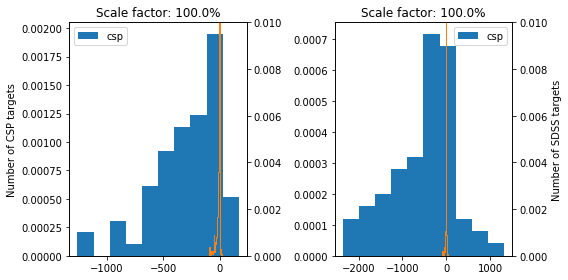

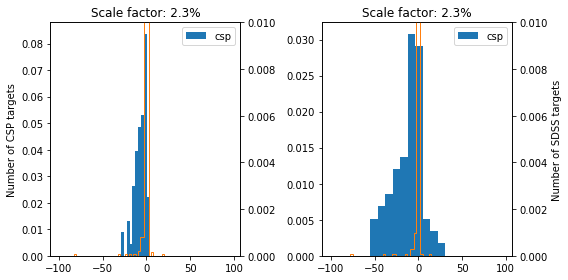

In [12]:
hist_coord_distributions(coordinates, 1)
hist_coord_distributions(coordinates, scale_factor)


In [13]:
def scatter_class_coordinates(coord_df, scale=1):
    """Scatter plot classification coordinates
    
    Args:
        coord_df (dataframe): Classification coordinates for CSP and SDSS
        scale        (float): Rescale CSP coordinates by the given value
    """
    
    sdss = coord_df.loc['SDSS']
    csp = coord_df.loc['CSP']
    
    fig, axis = plt.subplots()
    axis.scatter(sdss['x'], sdss['y'], s=10)
    axis.scatter(csp['x'] * scale, csp['y'] * scale, s=5)
    
    x_label = r'$\chi^2_{blue}$ (Ia) - $\chi^2_{blue}$ (91bg)'
    y_label = r'$\chi^2_{red}$ (Ia) - $\chi^2_{red}$ (91bg)'
    axis.set_xlabel(x_label)
    axis.set_ylabel(y_label)
    axis.set_title(f'Scale factor: {scale * 100 :.1f}%')


(-50, 50)

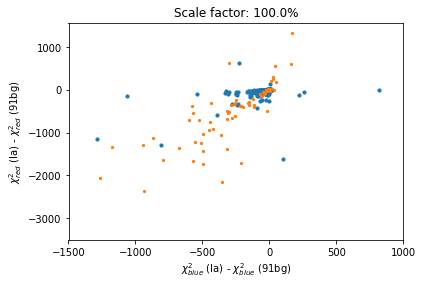

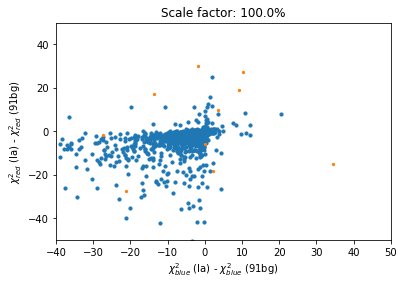

In [14]:
scatter_class_coordinates(coordinates)
plt.xlim(-1500, 1000)

scatter_class_coordinates(coordinates)
plt.xlim(-40, 50)
plt.ylim(-50, 50)


(-50, 50)

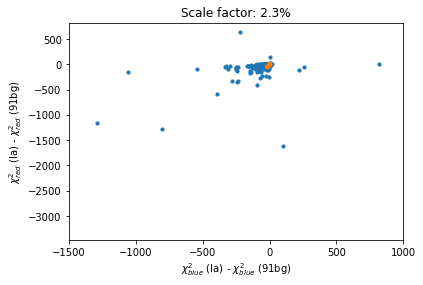

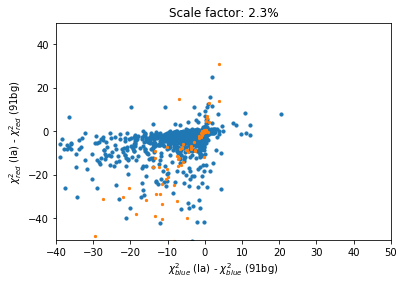

In [15]:
scatter_class_coordinates(coordinates, scale_factor)
plt.xlim(-1500, 1000)

scatter_class_coordinates(coordinates, scale_factor)
plt.xlim(-40, 50)
plt.ylim(-50, 50)


## FOM 

In [16]:
def plot_fom(coord_df, x_cut=0, y_cut=0, fom=None, figsize=(8, 8)):
    """Scatter plot classification coordinates and include FOM results
    
    Args:
        coord_df (dataframe): Classification coordinates for CSP and SDSS
        x_cut        (float): x cutoff used in FOM calculation
        y_cut        (float): y cutoff used in FOM calculation
        scale        (float): Rescale CSP coordinates by the given value
        figsize      (tuple): Size of the figure in inches
    """
    
    fig, axis = plt.subplots(figsize=figsize)

    sdss = coord_df.loc['SDSS']
    csp = coord_df.loc['CSP']
    
    axis.scatter(sdss.x, sdss.y, color='grey', alpha=.2)
    for sn_type, dataframe in coord_df.loc['CSP'].groupby('type'):  
        axis.scatter(dataframe.x, dataframe.y, label=sn_type, s=20)

    line_kwargs = dict(linestyle='--', color='black', alpha=.5)
    axis.axvline(x_cut, **line_kwargs)
    axis.axhline(y_cut, **line_kwargs, label=f'FOM = {fom: .2f}' if fom else fom)
        
    x_label = r'$\chi^2_{blue}$ (Ia) - $\chi^2_{blue}$ (91bg)'
    y_label = r'$\chi^2_{red}$ (Ia) - $\chi^2_{red}$ (91bg)'
    axis.set_xlabel(x_label)
    axis.set_ylabel(y_label)
    
    plt.legend()
    

(-100, 100)

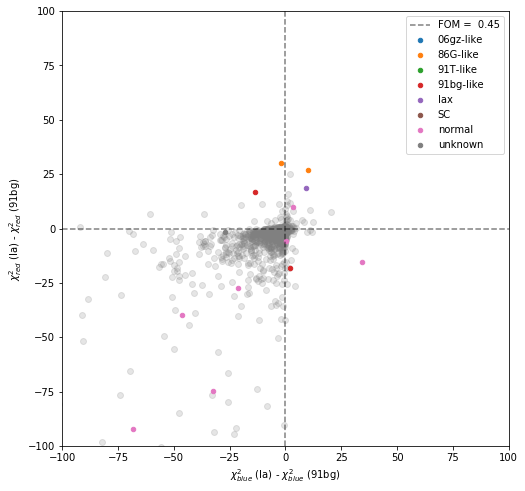

In [17]:
xcut = 0
ycut = 0

# Don't use targets without spectral classifications in FOM
_temp = coordinates[coordinates.type != 'unknown']
fom_val = fom.rectangular(_temp.type, _temp.x, _temp.y, xcut, ycut, '91bg-like')

plot_fom(coordinates, xcut, ycut, fom=fom_val)
plt.xlim(-100, 100)
plt.ylim(-100, 100)
